# Statistics
### Import modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.stats import pearsonr
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

### Load data

In [2]:
games_df = pd.read_json("data/games.json")

In [3]:
runs_df = None
for id, row in games_df.iterrows():
    try:
        run_df = pd.read_json("data/runs/{}.json".format(row["id"]))
    except Exception:
        print("Error opening file for {}".format(row["id"]))
        continue
    if run_df.empty or not (((run_df["game"] == row["name"]) & (run_df["region"] == "JPN / NTSC")).any() and ((run_df["game"] == row["name"]) & (run_df["region"] != "JPN / NTSC")).any()):
        continue
    if runs_df is None:
        runs_df = run_df
    else:
        runs_df = pd.concat([runs_df, run_df], ignore_index=True)

In [4]:
runs_df_raw = runs_df
runs_df

,id,game,player,player_location,time,category,region,platform,emulated
0,wzp87exy,(The) Final Fantasy Legend,Poxnor,None,406.0,Any %,JPN / NTSC,None,False
1,y99d3wny,(The) Final Fantasy Legend,baku_zero,jp,79.0,Any %,JPN / NTSC,Super Game Boy 2,False
2,y65ggwqz,(The) Final Fantasy Legend,gossyo,jp,80.0,Any %,JPN / NTSC,Super Game Boy 2,False
3,zxn42pem,(The) Final Fantasy Legend,gyre,None,3335.0,Any % (Glitchless),USA / NTSC,Game Boy Player,False
4,yodel6dm,(The) Final Fantasy Legend,RuneGlazeDonut,ca,98.0,Any %,JPN / NTSC,Super Game Boy,True
...,...,...,...,...,...,...,...,...,...
133932,zx8rnwkm,ZuPaPa!,OscarGAMZ,mx,1502.0,Any% 1P,None,Arcade,True
133933,zx4jw45y,Zwei: The Arges Adventure,Schtolteheim,us,471.0,Typing of Ys,USA / NTSC,PC,False
133934,y92rvorz,Zwei: The Arges Adventure,ayglCaptain,None,5999.0,Any%,None,PC,False
133935,m78x4q9z,Zwei: The Arges Adventure,aderentic,us,404.0,Typing of Ys,USA / NTSC,PC,False


In [5]:
drop_high = runs_df_raw['time'].quantile(q = 0.99)
drop_low = runs_df_raw['time'].quantile(q = 0.01)

runs_df = runs_df_raw[runs_df_raw['time'] > drop_low]
runs_df = runs_df_raw[runs_df_raw['time'] < drop_high]
runs_df = runs_df_raw.dropna(subset = ['region'])#.reset_index(drop=True)

#for game in runs_df["game"].unique():
#    if not (((runs_df["game"] == game) & (runs_df["region"] == "JPN / NTSC")).any() and ((runs_df["game"] == game) & (runs_df["region"] != "JPN / NTSC")).any()):
#        runs_df = runs_df[runs_df["game"] != game]

In [6]:
runs_df

,id,game,player,player_location,time,category,region,platform,emulated
0,wzp87exy,(The) Final Fantasy Legend,Poxnor,None,406.0,Any %,JPN / NTSC,None,False
1,y99d3wny,(The) Final Fantasy Legend,baku_zero,jp,79.0,Any %,JPN / NTSC,Super Game Boy 2,False
2,y65ggwqz,(The) Final Fantasy Legend,gossyo,jp,80.0,Any %,JPN / NTSC,Super Game Boy 2,False
3,zxn42pem,(The) Final Fantasy Legend,gyre,None,3335.0,Any % (Glitchless),USA / NTSC,Game Boy Player,False
4,yodel6dm,(The) Final Fantasy Legend,RuneGlazeDonut,ca,98.0,Any %,JPN / NTSC,Super Game Boy,True
...,...,...,...,...,...,...,...,...,...
133930,me9o622z,ZuPaPa!,NeroGamer120,mx,1610.0,,USA / NTSC,Arcade,True
133931,zp17x5rz,ZuPaPa!,JejuKyo,jp,1919.0,Any% 1P,JPN / NTSC,Arcade,True
133933,zx4jw45y,Zwei: The Arges Adventure,Schtolteheim,us,471.0,Typing of Ys,USA / NTSC,PC,False
133935,m78x4q9z,Zwei: The Arges Adventure,aderentic,us,404.0,Typing of Ys,USA / NTSC,PC,False


In [7]:
def transform_categorical(target_df, source_df, column_name):
    mapping = source_df[column_name].unique()
    for i in range(0, len(mapping)):
        target_df.loc[ target_df[column_name] == mapping[i], column_name + "_ord"] = i
    target_df[column_name + "_ord"] = target_df[column_name + "_ord"].astype(float)

In [8]:
runs_ordinals_df = runs_df.copy(deep = True)
transform_categorical(runs_ordinals_df, runs_df, "region")
transform_categorical(runs_ordinals_df, runs_df, "player_location")
transform_categorical(runs_ordinals_df, runs_df, "game")
transform_categorical(runs_ordinals_df, runs_df, "platform")
transform_categorical(runs_ordinals_df, runs_df, "category")

In [9]:
correlation_significances_region = {
    "Very high positive (> 0.9)": 0,
    "Very high negative (< -0.9)": 0,
    "High positive (> 0.7)": 0,
    "High negative (< -0.7)": 0,
    "Moderate positive (> 0.5)": 0,
    "Moderate negative (< -0.5)": 0,
    "Low positive (> 0.3)": 0,
    "Low negative (< -0.3)": 0,
    "Negligible (< 0.3, > -0.3)": 0
}

correlation_significances_player_location = {
    "Very high positive (> 0.9)": 0,
    "Very high negative (< -0.9)": 0,
    "High positive (> 0.7)": 0,
    "High negative (< -0.7)": 0,
    "Moderate positive (> 0.5)": 0,
    "Moderate negative (< -0.5)": 0,
    "Low positive (> 0.3)": 0,
    "Low negative (< -0.3)": 0,
    "Negligible (< 0.3, > -0.3)": 0
}

# oof
def map_corr(dict, corr):
    if corr >= 0.9:
        dict["Very high positive (> 0.9)"] += 1
    elif corr >= 0.7:
        dict["High positive (> 0.7)"] += 1
    elif corr >= 0.5:
        dict["Moderate positive (> 0.5)"] += 1
    elif corr >= 0.3:
        dict["Low positive (> 0.3)"] += 1
    elif corr > -0.3:
        dict["Negligible (< 0.3, > -0.3)"] += 1
    elif corr > -0.5:
        dict["Low negative (< -0.3)"] += 1
    elif corr > -0.7:
        dict["Moderate negative (< -0.5)"] += 1
    elif corr > -0.9:
        dict["High negative (< -0.7)"] += 1
    else:
        dict["Very high negative (< -0.9)"] += 1

reject_H0_region = 0
reject_H0_player_location = 0


time_player_location_corr = 0
time_region_corr = 0
total = 0

MIN_RECORDS = 75

max_corr_df = None
max_corr = 0
max_corr_abs = 0

# for top n games
for id, game in runs_ordinals_df["game_ord"].value_counts().to_frame().head(500).iterrows():
    game_df = runs_ordinals_df.where(runs_ordinals_df["game_ord"] == id).dropna()
    if game_df.shape[0] < MIN_RECORDS:
            continue
    
    # for top m categories
    for id, category in game_df["category_ord"].value_counts().to_frame().head(100).iterrows():
        cat_game_df = game_df.where(game_df["category_ord"] == id).dropna()
        if cat_game_df.shape[0] < MIN_RECORDS:
            continue
        total += 1
        corr, p = pearsonr(cat_game_df["time"], cat_game_df["region_ord"])
        map_corr(correlation_significances_region, corr)
        if abs(corr) > max_corr_abs:
            max_corr_abs = abs(corr)
            max_corr = corr
            max_corr_df = cat_game_df.copy(deep = True)
        if p < 0.05:
            reject_H0_region += 1
        corr, p = pearsonr(cat_game_df["time"], cat_game_df["player_location_ord"])
        map_corr(correlation_significances_player_location, corr)
        if p < 0.05:
            reject_H0_player_location += 1

H0: There is no significant linear correlation between time and region/player location
Ha: There is a significant linear correlation between time and region/player location

In [10]:
print("Reject H0 for region: {}".format(reject_H0_region))
print("Reject H0 for player location: {}".format(reject_H0_player_location))
print("From total games/categories: {}".format(total))

Reject H0 for region: 66
Reject H0 for player location: 18
From total games/categories: 238


In [11]:
print("\tCorrelation signigicance by region:")
pprint(correlation_significances_region, sort_dicts=False)
print("\tCorrelation signigicance by player location:")
pprint(correlation_significances_player_location, sort_dicts=False)

	Correlation signigicance by region:
{'Very high positive (> 0.9)': 0,
 'Very high negative (< -0.9)': 4,
 'High positive (> 0.7)': 1,
 'High negative (< -0.7)': 0,
 'Moderate positive (> 0.5)': 6,
 'Moderate negative (< -0.5)': 1,
 'Low positive (> 0.3)': 11,
 'Low negative (< -0.3)': 0,
 'Negligible (< 0.3, > -0.3)': 215}
	Correlation signigicance by player location:
{'Very high positive (> 0.9)': 0,
 'Very high negative (< -0.9)': 0,
 'High positive (> 0.7)': 0,
 'High negative (< -0.7)': 0,
 'Moderate positive (> 0.5)': 0,
 'Moderate negative (< -0.5)': 0,
 'Low positive (> 0.3)': 1,
 'Low negative (< -0.3)': 1,
 'Negligible (< 0.3, > -0.3)': 236}


In [12]:
print(max_corr_df[["game", "category", "time", "region", "player_location"]])

                              game       category    time      region  \
26840  Grand Theft Auto: Vice City  Any% (No SSU)  3385.0  JPN / NTSC   
26842  Grand Theft Auto: Vice City  Any% (No SSU)  5708.0  USA / NTSC   
26844  Grand Theft Auto: Vice City  Any% (No SSU)  5885.0  USA / NTSC   
26845  Grand Theft Auto: Vice City  Any% (No SSU)  6660.0  USA / NTSC   
26847  Grand Theft Auto: Vice City  Any% (No SSU)  3617.0  USA / NTSC   
...                            ...            ...     ...         ...   
27338  Grand Theft Auto: Vice City  Any% (No SSU)  3358.0  JPN / NTSC   
27339  Grand Theft Auto: Vice City  Any% (No SSU)  3329.0  JPN / NTSC   
27340  Grand Theft Auto: Vice City  Any% (No SSU)  3574.0  JPN / NTSC   
27342  Grand Theft Auto: Vice City  Any% (No SSU)  3689.0  JPN / NTSC   
27351  Grand Theft Auto: Vice City  Any% (No SSU)  4630.0  JPN / NTSC   

      player_location  
26840              de  
26842              us  
26844          gb/nir  
26845              pl  
268

In [13]:
corr = max_corr_df.corr()
display(corr.style.background_gradient(cmap='coolwarm'))

,time,region_ord,player_location_ord,game_ord,platform_ord,category_ord
time,1.000000,0.717838,-0.153735,nan,0.019647,nan
region_ord,0.717838,1.000000,-0.176130,nan,0.157478,nan
player_location_ord,-0.153735,-0.176130,1.000000,nan,0.173673,nan
game_ord,nan,nan,nan,nan,nan,nan
platform_ord,0.019647,0.157478,0.173673,nan,1.000000,nan
category_ord,nan,nan,nan,nan,nan,nan


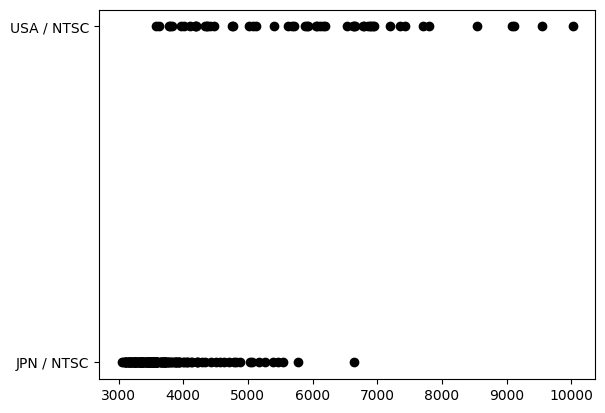

In [14]:
plt.plot(max_corr_df["time"], max_corr_df["region"], 'o', color='black');
plt.show()

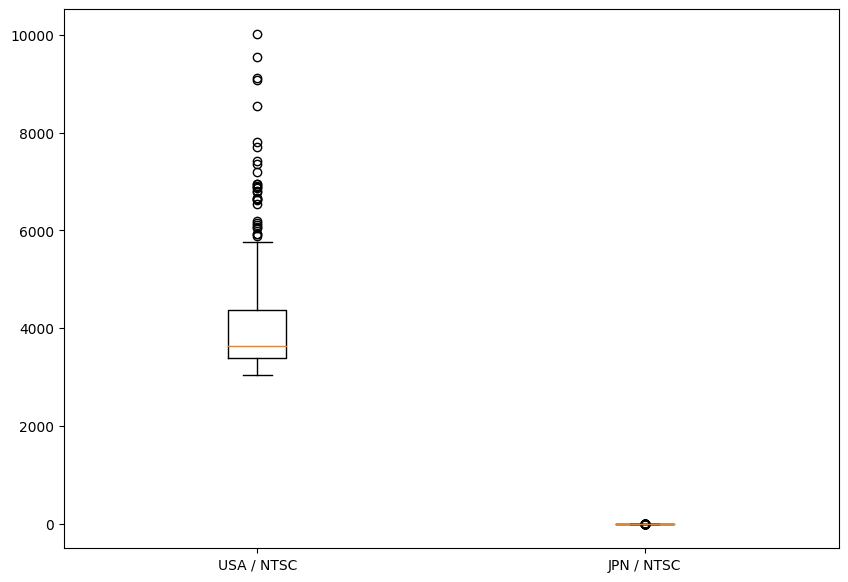

In [15]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
bp = ax.boxplot(max_corr_df[["time", "region_ord"]])
ax.set_xticklabels(['USA / NTSC', 'JPN / NTSC'])
plt.show()